# Simulate proteome time profiles.
## Start from measured proteome that is already hedged: necessary to enable lactate usage later?
## Allow protein degradation--otherwise too constrained?

In [1]:
import seaborn as sns
import pandas as pd

sns.plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.float_format', lambda x: '%.3g' % x)
%matplotlib inline

In [2]:
PROTOTYPE = False
PROTEASE = True

In [3]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE, protease=PROTEASE)
solver = helper.solver
me = solver.me

In [4]:
print len(me.metabolites), len(me.reactions)

7044 17146


In [5]:
from dynamicme.dynamic import get_undiluted_cplxs

undiluted_cplxs = get_undiluted_cplxs(solver)

In [6]:
len(undiluted_cplxs)

15

In [7]:
cplx_concs_max = get_cplx_concs(solver)

In [8]:
len(cplx_concs_max)

1432

In [9]:
mu_me = me.solution.x_dict['biomass_dilution']
print 'mu of ME for growth maximization:', mu_me

mu of ME for growth maximization: 0.9208984375


In [10]:
from dynamicme.dynamic import DelayedDynamicME

dyme = DelayedDynamicME(solver)
dyme.delay_model.solver.set_realopts('lp', {'Feasibility tol':1e-15,'Optimality tol':1e-15})
dsolver = dyme.delay_model.solver

# Test the optimal predicted proteome--with active protein degradation

In [11]:
C_meas = 'Glucose'
###
df_meta = pd.read_csv('/home/laurence/ME/data/cobrame/sectors/proteomics_conds.csv')
mu_meas = df_meta[ df_meta.exp==C_meas].iloc[0]['Growth.rate..h.1.']
print 'Growth on %s = %g' % (C_meas, mu_meas)

Growth on Glucose = 0.58


In [12]:
df_meas = pd.read_csv('/home/laurence/ME/data/cobrame/sectors/schmidt_prot_mf.csv')
print df_meas.shape
#df_meas.head(2)

(51898, 8)


In [13]:
df_meas_C = df_meas[ df_meas.condition==C_meas]
#df_meas_C.head(2)

In [14]:
meas_dict = {r['Bnumber']:r['mf'] for i,r in df_meas_C.iterrows()}

In [15]:
sum(meas_dict.values())

0.9999999999999964

# Get simulated proteome closest to measured
- L1 (drops potential outliers)
- L2 (tries to get match everything)
    - should pre-process to remove outliers?

In [16]:
%%time

from cobrawe.fit import FitME

fit = FitME(me)
#me_nlp = fit.me_nlp
#me_nlp.compiled_expressions = None
#sol,stat,hs = fit.fit_mass_frac(meas_dict, mu_meas, norm='l1')

CPU times: user 110 ms, sys: 10 ms, total: 120 ms
Wall time: 122 ms


## Initialize dynamicME with this feasible initial proteome and growth rate

In [17]:
cplx_concs = get_cplx_concs(solver)
cplx_conc_dict0 = dict(cplx_concs)

In [18]:
import json

# fname = '/home/laurence/ME/data/dynamicME/production/cplx_conc_opt_%s.csv'%C_meas
# print fname
# with open(fname,'w') as f:
#     json.dump(cplx_conc_dict0, f)

# Validate mixed substrate uptake hierarchy--Beg et al. (2007) MSB

In [19]:
import warnings

T = 10   # hours
V = 1.   # L
X0 = 0.00675 / V  # g/L
c0_dict = {'glc__D_e': 0.4,
           'lac__L_e': 0.4,
           'malt_e': 0.4,
           'gal_e': 0.4,
           'glyc_e':0.4,
           'ac_e': 0.0}

### Convert from g/L to mmol
mids_remove = []
for mid,c in c0_dict.iteritems():
    try:        
        met = me.metabolites.get_by_id(mid)    
        c0_dict[met.id] = c / met.formula_weight * 1000
    except KeyError:
        warnings.warn('Model has no metabolite: %s. Will remove it from c0_dict' % mid)
        mids_remove.append(mid)

for mid in mids_remove:
    c0_dict.pop(mid)
        
### Set max uptake rate
LB_EX = -10.
LB_O2 = -20.

lb_dict={}
ub_dict={}

for mid in c0_dict.keys():
    try:
        rxn = dyme.get_exchange_rxn(mid)    
        if rxn.id is 'EX_o2_e':
            lb = LB_O2
        else:
            lb = LB_EX
        rxn.lower_bound = lb
        lb_dict[rxn.id] = lb
    except KeyError:
        warnings.warn('Model has no metabolite: '+ mid)

me.reactions.EX_o2_e.lower_bound = -20.
lb_dict[me.reactions.EX_o2_e.id] = -20.
        
print c0_dict
print lb_dict

{'glyc_e': 4.34339676647141, 'malt_e': 1.1685776026677226, 'lac__L_e': 4.4908498933423155, 'gal_e': 2.220299442904667, 'ac_e': 0.0, 'glc__D_e': 2.220299442904667}
{u'EX_glyc_e': -10.0, u'EX_o2_e': -20.0, u'EX_gal_e': -10.0, u'EX_lac__L_e': -10.0, u'EX_malt_e': -10.0, u'EX_ac_e': -10.0, 'EX_glc__D_e': -10.0}


In [20]:
solver.set_realopts('lp', {'Feasibility tol':1e-15, 'Optimality tol':1e-15})

In [21]:
from cobrame import MetabolicReaction

if PROTOTYPE:
    fluxes_plot = ['ACONTa_CPLX0-7760_mod_4fe4s', 'ACONTb_CPLX0-7760_mod_4fe4s', 'ACKr_reverse']
else:
    #fluxes_plot = [r.id for r in dsolver.me.reactions if isinstance(r,MetabolicReaction)]
    fluxes_plot = [r.id for r in dsolver.me.reactions]

In [ ]:
len(fluxes_plot)

20040

In [ ]:
%%time
extra_rxns_tracked = list(set(['EX_o2_e'] + fluxes_plot + ['biomass_dilution']))

T = 20
dt = 0.5
H = dt

result = dyme.simulate_batch(
    T,    
    c0_dict,
    X0,
    prec_bs=1e-3,
    ZERO_CONC=0.,
    extra_rxns_tracked=extra_rxns_tracked,
    lb_dict={},
    verbosity=2,
    dt = dt,
    H = H,
    cplx_conc_dict0=cplx_conc_dict0)

Metabolite glyc_e available.
Using default LB=-1000 for EX_glyc_e
Metabolite ac_e depleted.
Metabolite lac__L_e available.
Using default LB=-1000 for EX_lac__L_e
Metabolite malt_e available.
Using default LB=-1000 for EX_malt_e
Metabolite gal_e available.
Using default LB=-1000 for EX_gal_e
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc__D_e
Computing new uptake rates


### Save results

In [ ]:
import json
result2 = result.copy()
result2.keys()
result2.pop('basis')

with open('/home/laurence/ME/data/dynamicME/production/validation1_uptake_hier_sim_opt0_protease_R02.json','w') as f:
    json.dump(result2, f)

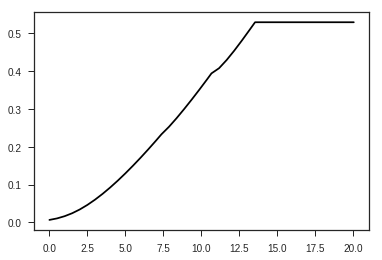

In [52]:
import seaborn as sns
%matplotlib inline

sns.plt.plot(result['time'], result['biomass'])

In [53]:
ex_met_rxn_dict = {m: {'rxn':dyme.get_exchange_rxn(m), 'mw':me.metabolites.get_by_id(m).formula_weight} for m in c0_dict.keys()}
ex_met_rxn_dict

{'ac_e': {'mw': 59.04402, 'rxn': <Reaction EX_ac_e at 0x7fbfd66e7ed0>},
 'gal_e': {'mw': 180.15588, 'rxn': <Reaction EX_gal_e at 0x7fbfd672a850>},
 'glc__D_e': {'mw': 180.15588,
  'rxn': <Reaction EX_glc__D_e at 0x7fbfd671ec50>},
 'glyc_e': {'mw': 92.09382, 'rxn': <Reaction EX_glyc_e at 0x7fbfd671e250>},
 'lac__L_e': {'mw': 89.07, 'rxn': <Reaction EX_lac__L_e at 0x7fbfd670d410>},
 'malt_e': {'mw': 342.29648, 'rxn': <Reaction EX_malt_e at 0x7fbfd6782c50>}}

In [54]:
import pandas as pd

df_conc = pd.DataFrame(result['concentration'])
### Convert concentrations to g/L
for mid, vals in ex_met_rxn_dict.iteritems():
    df_conc[mid] = df_conc[mid] * vals['mw'] * 0.001

df_time = pd.DataFrame({'time':t, 'biomass':b} for t,b in zip(result['time'], result['biomass']))
df_flux = pd.DataFrame(result['ex_flux'])
df_mu   = pd.DataFrame({'mu':result['growth_rate']})
df_result = pd.concat([df_time, df_conc, df_flux, df_mu], axis=1)

In [55]:
dsplot = pd.melt(df_result, id_vars='time', value_vars=['biomass','ac_e','gal_e','glc__D_e','glyc_e','lac__L_e','malt_e'])
dsplot.time = pd.to_numeric(dsplot.time)
dsplot['category'] = 'Metabolite'
dsplot.loc[ dsplot.variable=='biomass', 'category'] = 'Biomass'

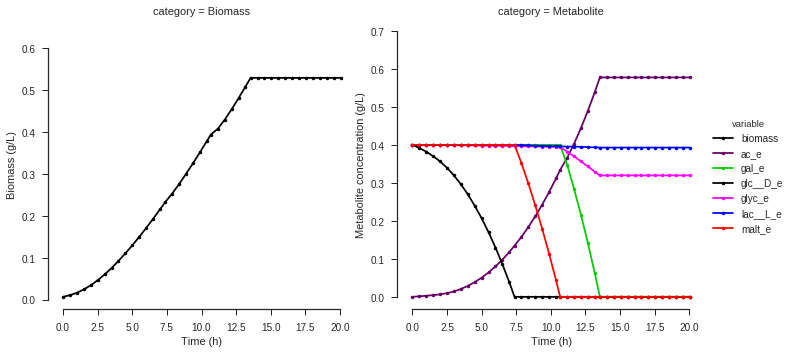

In [56]:
sns.set_style('ticks')

colors = [
'#000000', # biomass
'#660066', # acetate
'#00CC00', #'#00FF00', # galactose
'#000000', # glucose
'#FF00FF', # glycerol
'#0000FF', # lactate
'#FF0000', # maltose
]

colpal = sns.color_palette(colors)
sns.set_palette(colpal)

g = sns.FacetGrid(data=dsplot, hue='variable', col='category', sharey=False, size=5)

g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
for i,ax in enumerate(g.axes.flat):
    ylim = ax.get_ylim()
    ax.set_ylim((ylim[0],ylim[1]*1.2))
    if i==0:
        ax.set_ylabel('Biomass (g/L)')
    else:
        ax.set_ylabel('Metabolite concentration (g/L)')
g.set_xlabels('Time (h)')
g.add_legend()

sns.despine(offset=1, trim=True)

In [ ]:
g.savefig('/home/laurence/ME/figures/persistME/beg_init_opt_protease_R02.pdf')
g.savefig('/home/laurence/ME/figures/persistME/beg_init_opt_protease_R02.svg')
g.savefig('/home/laurence/ME/figures/persistME/beg_init_opt_protease_R02.eps')

# DEBUG

In [59]:
result['growth_rate']

[nan,
 1.1748046875,
 1.0947265625,
 0.9482421875,
 0.81640625,
 0.6962890625,
 0.5947265625,
 0.51171875,
 0.4453125,
 0.3916015625,
 0.34765625,
 0.3115234375,
 0.28125,
 0.255859375,
 0.234375,
 0.2158203125,
 0.171875,
 0.1796875,
 0.17578125,
 0.16796875,
 0.16015625,
 0.15234375,
 0.14453125,
 0.0693359375,
 0.1064453125,
 0.115234375,
 0.1171875,
 0.115234375,
 0.1103515625,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [67]:
ind_dbg = 29
result['growth_rate'][ind_dbg]
cplx_conc_dbg = result['complex'][ind_dbg]

In [68]:
dyme.delay_model.update_cplx_concs(cplx_conc_dbg)

In [70]:
%%time
#x,stat,hs = dsolver.solvelp(1e-25, basis=dsolver.feas_basis)
x,stat,hs = dsolver.solvelp(1e-15, basis=dsolver.feas_basis)

CPU times: user 2min 9s, sys: 1.21 s, total: 2min 10s
Wall time: 2min 10s


In [71]:
print stat

1


In [133]:
me.complex_data.ribosome.stoichiometry

defaultdict(float,
            {'RplA_mono': 1.0,
             'RplB_mono': 1.0,
             'RplC_mono': 1.0,
             'RplD_mono': 1.0,
             'RplE_mono': 1.0,
             'RplF_mono': 1.0,
             'RplI_mono': 1.0,
             'RplJ_mono': 1.0,
             'RplK_mono': 1.0,
             'RplM_mono': 1.0,
             'RplN_mono': 1.0,
             'RplO_mono': 1.0,
             'RplP_mono': 1.0,
             'RplQ_mono': 1.0,
             'RplR_mono': 1.0,
             'RplS_mono': 1.0,
             'RplT_mono': 1.0,
             'RplU_mono': 1.0,
             'RplV_mono': 1.0,
             'RplW_mono': 1.0,
             'RplX_mono': 1.0,
             'RplY_mono': 1.0,
             'RpmA_mono': 1.0,
             'RpmB_mono': 1.0,
             'RpmC_mono': 1.0,
             'RpmD_mono': 1.0,
             'RpmE_mono': 1.0,
             'RpmF_mono': 1.0,
             'RpmG_mono': 1.0,
             'RpmH_mono': 1.0,
             'RpmI_mono': 1.0,
             'RpmJ_m

In [139]:
me.metabolites.RNA_b3851.reactions

frozenset({<GenericFormationReaction RNA_b3851_to_generic_16s_rRNAs at 0x7fbfd425c690>,
           <Reaction DM_RNA_b3851 at 0x7fbfd7244f10>,
           <TranscriptionReaction transcription_TU0_1181_from_RpoD_mono at 0x7fbfdab7c550>,
           <TranscriptionReaction transcription_TU0_1181_from_RPOH_MONOMER at 0x7fbfdab7c7d0>,
           <TranscriptionReaction transcription_TU0_14486_from_RpoD_mono at 0x7fbfdaeb0590>})

In [137]:
me.metabolites.generic_16s_rRNAs.reactions

frozenset({<ComplexDegradation degradation_ribosome_ClpAXP at 0x7fbfd38e4f50>,
           <ComplexDegradation degradation_ribosome_Lon at 0x7fbfd3bc2c50>,
           <ComplexFormation formation_ribosome at 0x7fbfd426a1d0>,
           <GenericFormationReaction RNA_b3851_to_generic_16s_rRNAs at 0x7fbfd425c690>,
           <GenericFormationReaction RNA_b3968_to_generic_16s_rRNAs at 0x7fbfd425c790>,
           <GenericFormationReaction RNA_b3756_to_generic_16s_rRNAs at 0x7fbfd425c810>,
           <GenericFormationReaction RNA_b3278_to_generic_16s_rRNAs at 0x7fbfd425c890>,
           <GenericFormationReaction RNA_b4007_to_generic_16s_rRNAs at 0x7fbfd425c910>,
           <GenericFormationReaction RNA_b2591_to_generic_16s_rRNAs at 0x7fbfd425c990>,
           <GenericFormationReaction RNA_b0201_to_generic_16s_rRNAs at 0x7fbfd425ca10>})

In [129]:
met = me.metabolites.RNA_b0508
dsome = me.metabolites.RNA_degradosome
for rxn in met.reactions:
    if 'translation' in rxn.id:
        print '%-25.20s%-25.20s%-50s' % (rxn.id, met.id, rxn.metabolites[met])
        print '%-25.20s%-25.20s%-50s' % (rxn.id, dsome.id, rxn.metabolites[dsome])

translation_b0508        RNA_b0508                -0.00149519890260631*mu - 0.00058537037037037 - 0.0538271604938272*(mu + 0.3915)/mu
translation_b0508        RNA_degradosome          -2.30030600400971e-7*mu - 9.00569800569801e-8     


In [145]:
me.reactions.translation_b0508.metabolites

{<Complex Rrf_mono at 0x7fbfda248410>: -2.62130898398882e-7*mu,
 <Complex Fmt_mono_mod_mg2_mod_k at 0x7fbfda248810>: -1.80324164444648e-7*mu,
 <Complex Def_mono_mod_1:fe2 at 0x7fbfda248f10>: -2.72438972852433e-7*mu,
 <Complex InfB_mono at 0x7fbfda255990>: -4.45382843794892e-6*mu,
 <Complex Tsf_mono at 0x7fbfda255e50>: -0.0010982905982906*mu,
 <Complex PrfC_mono at 0x7fbfda264650>: -4.27350427350427e-6*mu,
 <Complex InfA_mono at 0x7fbfda264850>: -4.27350427350427e-6*mu,
 <Complex FusA_mono at 0x7fbfda2b6bd0>: -0.0010982905982906*mu,
 <Complex InfC_mono at 0x7fbfda2b6f50>: -4.27350427350427e-6*mu,
 <Constraint protein_biomass at 0x7fbfdb148e50>: 29.367514999999997,
 <Constraint mRNA_biomass at 0x7fbfdb15a090>: -13.3426824641975*(mu + 0.3915)/mu,
 <GenericComponent generic_RF at 0x7fbfda264f50>: -1.58420211712986e-7*mu,
 <GenericComponent generic_Tuf at 0x7fbfda2b6890>: -0.0010982905982906*mu,
 <GenerictRNA generic_tRNA_UGU_cys__L_c at 0x7fbfda248210>: -4,
 <GenerictRNA generic_tRNA_UCU_s

In [116]:
import numpy as np

vtrsl = np.median([rxn.x for rxn in me.reactions.query('translation') if rxn.x > 0])
print vtrsl

8.70211994821e-07


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4 RuntimeWarning: divide by zero encountered in double_scalars


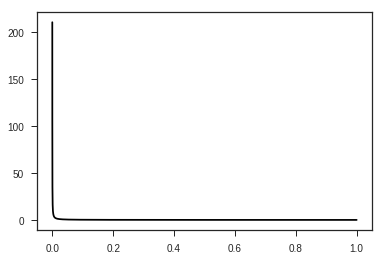

In [148]:
a = 0.0538271604938272
b = 0.3915
def f_deg(mu):
    y = a*(mu+b)/mu
    return y

mus = np.linspace(0,1, num=10000)
ss  = [f_deg(m) for m in mus]

sns.plt.plot(mus, ss)

# PLOT

In [152]:
dsolver.me.complex_data.get_by_id('CPLX0-1142').formation

<ComplexFormation formation_CPLX0-1142 at 0x7fbfda274390>

In [ ]:
if PROTOTYPE:
    complexes_plot = ['IPPMIa_E_c', 'ACKr_reverse_E_c', 'CPLX0-7760_mod_4fe4s','CPLX0-7761_mod_4fe4s']
else:
    complexes_plot = ['3-ISOPROPYLMALISOM-CPLX_mod_4fe4s', 'ACETATEKINA-MONOMER_mod_mg2', 'CPLX0-7659']

In [ ]:
fluxes_plot2 = []

for rid in fluxes_plot:
    rxn = dsolver.me.reactions.get_by_id(rid)
    try:
        if abs(rxn.x) > 20:
            fluxes_plot2.append(rxn.id)
    except:
        pass
        
print len(fluxes_plot2)

In [ ]:
df_mu = pd.DataFrame([{'time':t, 'variable':'growth_rate', 'value':c, 'category':'growth'} for t,c in zip(result['time'], result['growth_rate'])] )

try:
    df_complex = pd.DataFrame([{'time':t, 'complex':c, 'abundance':cdict[c]} 
                               for t,cdict in zip(result['time'], result['complex']) for c in complexes_plot] )
    df_complex.loc[:,'category'] = 'complex'
except KeyError:
    pass

df_mflux = pd.DataFrame([{'time':t, 'rxn':c, 'flux':cdict[c]} 
                           for t,cdict in zip(result['time'], result['rxn_flux']) for c in fluxes_plot2] )
try:
    df_mflux.loc[:,'category'] = 'flux'
except:
    pass

dsplot_all = pd.concat([dsplot,
                        df_mu,
                          df_complex.rename(columns={'complex':'variable', 'abundance':'value'}),
                          df_mflux.rename(columns={'rxn':'variable', 'flux':'value'})])

In [ ]:
sns.set_style('ticks')
palette = sns.color_palette('muted', len(dsplot_all.variable.unique()))
g = sns.FacetGrid(data=dsplot_all, hue='variable', sharey=False, size=3, col='category', palette=palette,
                  aspect=2, col_wrap=2, col_order=['Biomass','complex','Metabolite','flux','growth'])
g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
g.add_legend()

### In general, it seems virtual cell lacks capacity to replenish the continuously diluting proteome.
### Actually, not entirely true--see very rapid rise in ACK protein. But is that because it's cheaper (recall Hwa's overflow mechanism--ATP per protein cost)
### Need to start it off with much more ribosome?

In [ ]:
met = me.metabolites.get_by_id('FLAVODOXIN1-MONOMER')
for rxn in met.reactions:
    if rxn.x > 1e-15:
        print '%-35.30s%-55.50s%-50s' % (rxn.x, rxn.id, rxn.reaction)
        print

## Proteome mol (mass) fractions

In [ ]:
df_mass = pd.DataFrame([{'cplx':met.id, 'mass':met.mass} for met in me.metabolites if hasattr(met,'mass')])
df_cplx = pd.DataFrame([{'cplx':k, 'conc':v, 'time':result['time'][i]} for i,r in enumerate(result['complex']) for k,v in r.iteritems()])
df_cplx_mass = pd.merge(df_cplx, df_mass, on='cplx')

times = df_cplx_mass.time.unique()
for t in times:
    dfi = df_cplx_mass[ df_cplx_mass.time==t]
    masses = dfi.conc*dfi.mass
    mtot = masses.sum()
    mfs = masses/mtot
    b = (df_cplx_mass.time==t).values
    df_cplx_mass.loc[b,'mf'] = mfs

df_var = df_cplx_mass.groupby('cplx').mf.var().reset_index()
N_PLOT = 10
vary_cplxs = df_var.sort_values('mf', ascending=False)['cplx'][0:N_PLOT].values
vary_cplxs

df_cplx_mass[ df_cplx_mass.time==0].mf.sum()

from stressme.plot import stacked_bar

dsplot_cplx = df_cplx_mass[ df_cplx_mass.cplx.isin(vary_cplxs)]
dsplot_cplx.loc[:,'group'] = 'DynamicDelayedME'
stacked_bar('time', 'mf', dsplot_cplx, 'cplx', 'group', aspect=4)

## Just metabolic/transport enzymes

In [ ]:
from cobrame import Complex, MetabolicReaction

met_cplxs = list(set([met.id for rxn in me.reactions for met in rxn.metabolites if isinstance(rxn,MetabolicReaction) and isinstance(met, Complex)]))
met_cplxs = [m for m in met_cplxs if 'FLAVO' not in m]
print len(met_cplxs)

In [ ]:
df_cplx_mass[ (df_cplx_mass.cplx.isin(met_cplxs)) & (df_cplx_mass.time==10)].sort_values('conc',ascending=False)

In [ ]:
df_mass = pd.DataFrame([{'cplx':met.id, 'mass':met.mass} for met in me.metabolites if hasattr(met,'mass')])
df_cplx = pd.DataFrame([{'cplx':k, 'conc':v, 'time':result['time'][i]} for i,r in enumerate(result['complex']) for k,v in r.iteritems()])
df_cplx_mass = pd.merge(df_cplx, df_mass, on='cplx')

times = df_cplx_mass.time.unique()
for t in times:
    dfi = df_cplx_mass[ df_cplx_mass.time==t]
    masses = dfi.conc*dfi.mass
    mtot = masses.sum()
    mfs = masses/mtot
    b = (df_cplx_mass.time==t).values
    df_cplx_mass.loc[b,'mf'] = mfs

#df_var = df_cplx_mass[ df_cplx_mass.cplx.isin(met_cplxs)].groupby('cplx').mf.var().reset_index()
df_var = df_cplx_mass[ df_cplx_mass.cplx.isin(met_cplxs)].groupby('cplx').mf.mean().reset_index()
N_PLOT = 10
vary_cplxs = df_var.sort_values('mf', ascending=False)['cplx'][0:N_PLOT].values
vary_cplxs

df_cplx_mass[ df_cplx_mass.time==0].mf.sum()

from stressme.plot import stacked_bar

dsplot_cplx = df_cplx_mass
dsplot_cplx.loc[:,'name'] = dsplot_cplx.cplx
dsplot_cplx.loc[ ~dsplot_cplx.cplx.isin(vary_cplxs), 'name'] = 'Other'
dsplot_cplx = dsplot_cplx.groupby(['time','name']).mf.sum().reset_index()
dsplot_cplx.loc[:,'group'] = 'Metabolism and transport'
stacked_bar('time', 'mf', dsplot_cplx, 'name', 'group', aspect=4)

# Coarse

In [ ]:
#df_super = pd.read_csv('/home/laurence/ME/data/cobrame/proteome_letter/subsystem-supersystem-mapping.csv')
df_system = pd.read_csv('/home/laurence/ME/data/cobrame/proteome_letter/sub_supersystem.csv')
df_system.shape

# df_trsl = pd.DataFrame([{'rxn':k, 'v':v, 'time':result['time'][i]} for i,r in enumerate(result['rxn_flux']) for k,v in r.iteritems() if 'translation_' in k])

import re
patt = re.compile(r"protein_(b\d\d\d\d)_?\S?")

cplx_prot = pd.DataFrame([{'cplx':d.id, 'locus':re.findall(patt,k)[0]} for d in me.complex_data for k,v in d.stoichiometry.iteritems() if 'protein_b' in k])

df_mass = pd.DataFrame([{'cplx':met.id, 'mass':met.mass} for met in me.metabolites if hasattr(met,'mass')])
df_cplx = pd.DataFrame([{'cplx':k, 'conc':v, 'time':result['time'][i]} for i,r in enumerate(result['complex']) for k,v in r.iteritems()])
df_cplx_mass = pd.merge(df_cplx, df_mass, on='cplx')

times = df_cplx_mass.time.unique()
for t in times:
    dfi = df_cplx_mass[ df_cplx_mass.time==t]
    masses = dfi.conc*dfi.mass
    mtot = masses.sum()
    mfs = masses/mtot
    b = (df_cplx_mass.time==t).values
    df_cplx_mass.loc[b,'mf'] = mfs

df_cplx_mass = pd.merge(df_cplx_mass, cplx_prot, on='cplx', how='left')

In [ ]:
#syslevel = 'Subsystem'
syslevel = 'Supersystem'

df_level = df_system[['gene',syslevel]].drop_duplicates()

df_cplx_sub = pd.merge(df_cplx_mass, df_level, left_on='locus', right_on='gene', how='left')
df_cplx_sub.loc[ df_cplx_sub[syslevel].isnull(), syslevel] = 'Ungrouped'

df_mf_sector = df_cplx_sub.groupby(['time',syslevel]).mf.sum().reset_index()
# Renormalize to 1
dsplot_sector = df_mf_sector.copy()
for t in dsplot_sector.time.unique():
    b = dsplot_sector.time==t
    mtot = sum(dsplot_sector.loc[b,'mf'])
    dsplot_sector.loc[b, 'mf'] = dsplot_sector.loc[b, 'mf']/mtot

from stressme.plot import stacked_bar

dsplot_sector.loc[:,'group'] = syslevel
g = stacked_bar('time', 'mf', dsplot_sector, syslevel, 'group', size=5, aspect=3)

# Degradation fluxes

In [ ]:
df_degr = pd.DataFrame([{'time':result['time'][i], 'rxn':k, 'v':v} for i,r in enumerate(result['rxn_flux']) for k,v in r.iteritems() if 'degradation_' in k])

In [ ]:
df_degr.v.max()

In [ ]:
df_degr[ (df_degr.v > 1e-15)]

In [ ]:
me.reactions.degradation_Lon_Lon.reaction

In [ ]:
me.reactions.formation_Lon.reaction

In [ ]:
df_flux_all = pd.DataFrame([{'time':result['time'][i], 'rxn':k, 'v':v} for i,r in enumerate(result['rxn_flux']) for k,v in r.iteritems()])

In [ ]:
df_flux_all[ df_flux_all.rxn.str.contains('formation_CPLX_dummy')].v.max()

In [ ]:
df_flux_all[ df_flux_all.rxn.str.contains('dummy') & (df_flux_all.v > 1e-15)]

In [ ]:
for rxn in me.reactions:
    if abs(rxn.objective_coefficient) > 0:
        print rxn.id, '\t', rxn.reaction

In [ ]:
df_flux_all[ df_flux_all.rxn.str.contains('dummy_reaction')]

## df_cplx_mass[ df_cplx_mass.cplx.str.contains('dummy')]